<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Brain_Tumor_Detection%C2%B6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/brain_tumor.zip"
!unzip -qo brain_tumor.zip 
!rm brain_tumor.zip

--2021-01-05 03:00:09--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/brain_tumor.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.96
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7919366 (7.6M) [application/zip]
Saving to: ‘brain_tumor.zip’

brain_tumor.zip     100%[===================>]   7.55M  3.17MB/s    in 2.4s    

2021-01-05 03:00:12 (3.17 MB/s) - ‘brain_tumor.zip’ saved [7919366/7919366]



In [ ]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dropout,MaxPool2D, ReLU
from keras.layers import Conv2D, Reshape

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [ ]:
image_dir="brain_tumor_dataset/"

os.makedirs('brain_tumor_dataset/augmented-images')
os.makedirs('brain_tumor_dataset/augmented-images/yes')
os.makedirs('brain_tumor_dataset/augmented-images/no')

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
  data_generator = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
  
  for filename in listdir(file_dir):
    image = cv2.imread(file_dir + '/' + filename)
    image = image.reshape((1,)+image.shape)
    save_prefix = 'aug_' + filename[:-4]
    i = 0
    for batch in data_generator.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
          i += 1
          if i > n_generated_samples:
              break

In [ ]:
augmented_data_path ='brain_tumor_dataset/augmented-images/'

augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [ ]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

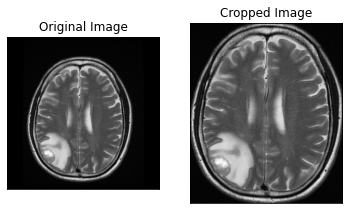

In [ ]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 224, 224, 3)
y shape is: (2064, 1)


In [ ]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

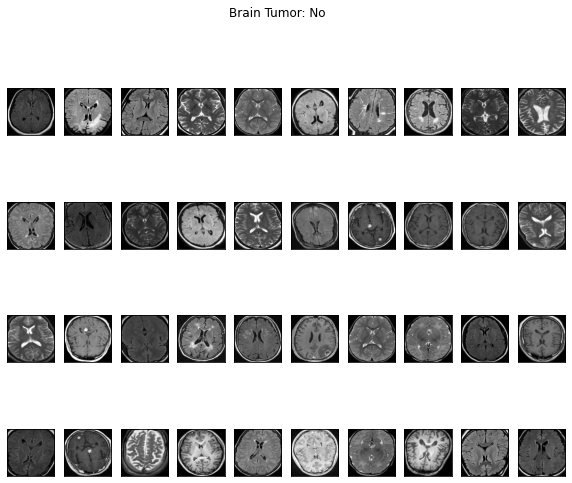

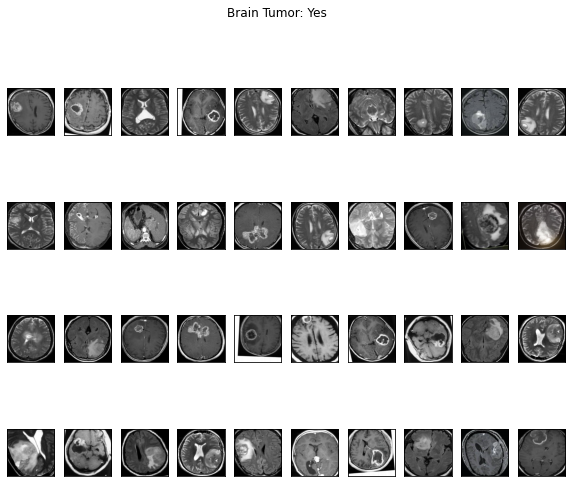

In [ ]:
plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.1)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1857
number of validation examples = 104
number of test examples = 103


In [ ]:
model=Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis = 3, name = 'bn1'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 222, 222, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 53, 53, 32)        1

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
124/124 [==============================] - 10s 24ms/step - loss: 1.1694 - accuracy: 0.5484 - val_loss: 0.6555 - val_accuracy: 0.6635
Epoch 2/20
124/124 [==============================] - 2s 20ms/step - loss: 0.6564 - accuracy: 0.7033 - val_loss: 0.6201 - val_accuracy: 0.5962
Epoch 3/20
124/124 [==============================] - 2s 20ms/step - loss: 0.4992 - accuracy: 0.7850 - val_loss: 0.5387 - val_accuracy: 0.7115
Epoch 4/20
124/124 [==============================] - 2s 20ms/step - loss: 0.4737 - accuracy: 0.7890 - val_loss: 0.4708 - val_accuracy: 0.8077
Epoch 5/20
124/124 [==============================] - 2s 20ms/step - loss: 0.4234 - accuracy: 0.8078 - val_loss: 0.3814 - val_accuracy: 0.7885
Epoch 6/20
124/124 [==============================] - 2s 20ms/step - loss: 0.4091 - accuracy: 0.8064 - val_loss: 0.3585 - val_accuracy: 0.8654
Epoch 7/20
124/124 [==============================] - 2s 20ms/step - loss: 0.3464 - accuracy: 0.8554 - val_loss: 0.3207 - val_accuracy: 0.817

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 26ms/step - loss: 0.4899 - accuracy: 0.8252


[0.4899337887763977, 0.8252426981925964]

Text(0.5, 1.0, 'Accuracy Curves')

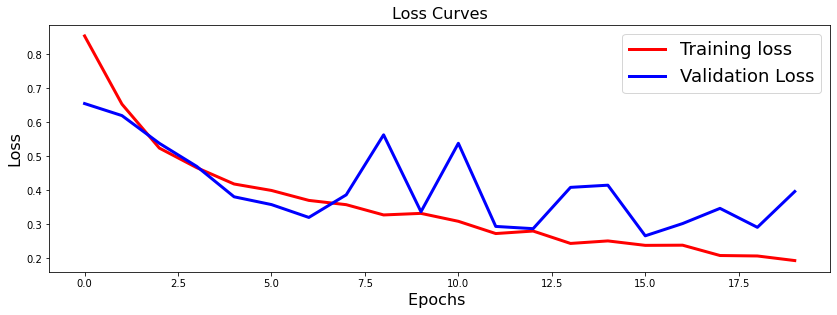

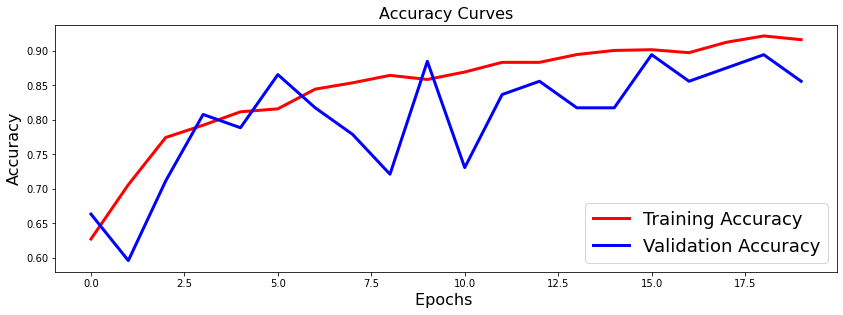

In [ ]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', 
                      include_top=False, 
                      input_shape=(224, 224, 3))

In [ ]:
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
   
    x = Flatten()(x)
    
    fine_tune_at = 180

    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False
    
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    predictions = Dense(1, activation='sigmoid')(x) 
    
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model

In [ ]:
class_list = ["No", "Yes"]
FC_LAYERS = [512]
dropout = 0.5

model = build_final_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_6[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________________

In [ ]:
len(model.layers)

248

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, epochs=20, validation_data=(X_val, y_val),
                    steps_per_epoch=1857 // 32, validation_steps=104 // 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


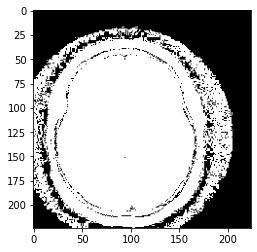

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = '/content/brain_tumor_dataset/augmented-images/no/aug_1 no._0_283.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#img_tensor = preprocess_input(img_tensor)

featuremap = model.predict(img_tensor)
plt.imshow(featuremap)
plt.imshow(img_tensor[0])
print (img_tensor.shape)

In [ ]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]]
activation_modelfig = Model(inputs=model.input, outputs=layer_outputs)
activationsfig = activation_modelfig.predict(img_tensor)

(1, 222, 222, 32)


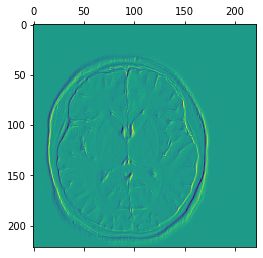

In [ ]:
first_layer_activation = activationsfig[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

In [ ]:
print(len(model.layers))

12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

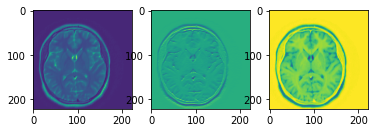

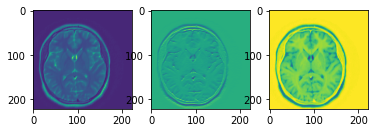

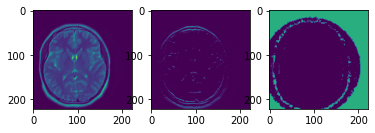

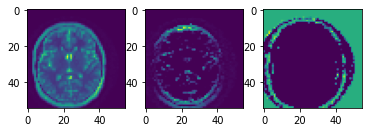

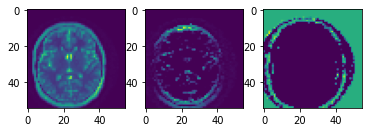

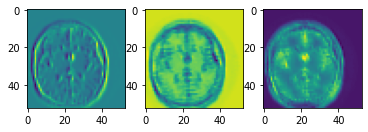

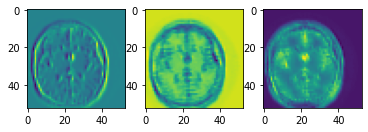

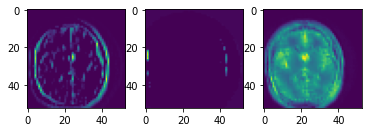

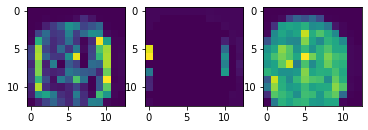

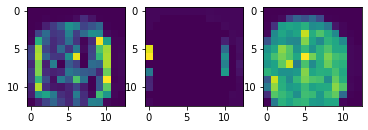

In [ ]:
for i in range(0,len(model.layers)-2):
    current_layer_activation = activationsfig[i]
    ns = current_layer_activation.shape[-1]
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    plt.subplot(131)
    plt.imshow(current_layer_activation[0, :, :, 0], cmap='viridis')
    
    ax3 = fig.add_subplot(132)
    plt.subplot(132)
    plt.imshow(current_layer_activation[0, :, :, int(ns/2)], cmap='viridis')
    
    ax5 = fig.add_subplot(133)
    plt.subplot(133)
    plt.imshow(current_layer_activation[0, :, :, ns-1], cmap='viridis')